# Masking CA3 for Spatial Gaussian fits

## 1. Loading and fit Gaussians to the CA3 region.

Take a look at CA3 and fit a Gaussian to it without masking. 

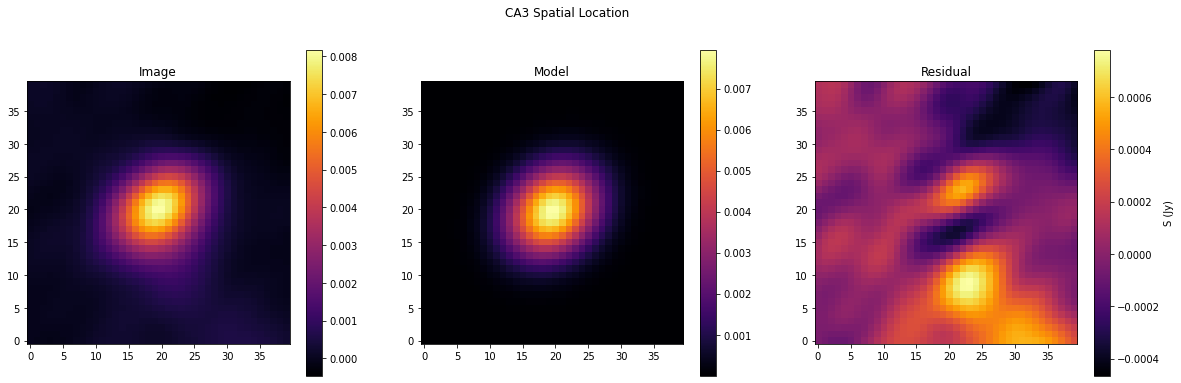

Parameter Error

7.999545172e-03 2.766034230e-04

2.90917076e+02 1.575641425e-07

1.451823752e+01 1.429353131e-07

3.52549256e-06 1.311808499e-07

4.30829914e-06 1.674772716e-07

-2.232956809e+00 1.073331240e-01



In [9]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

#Accessing Cube Data

directory1 = '/orange/adamginsburg/w51/FITS/W51n_cont_briggsSC_tclean.image.fits'

cube = SpectralCube.read(directory1, format='fits')
cube1 = cube[0,:,:]
x, y = 3295, 3580
size = 20

cube1_cutout = cube1[y - size:y + size, x - size:x + size]
yy, xx = cube_cutout.spatial_coordinate_map

cord = cube1.world[y,x]

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=0.03 * (u.Jy/u.beam),
                                   x_stddev=1.111111e-5 * u.degree, y_stddev=1.111111e-5 * u.degree, theta=1.4*u.rad)

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube1_cutout

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)

              
plt.figure(figsize=(20, 6))
plt.suptitle("CA3 Spatial Location")

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube1_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube1_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')

plt.show()

#saveplotfig_gaussianfit()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")

As we can see, the residual is a bit messy. We can fit a better model to the region with masking.

## 2. Signal Masking

First, cuttout the cube to make the `cube.sigma_clip_spectrally(3)` step and processing quicker. We do not need most of the cube.

In [43]:
cube = SpectralCube.read(directory1, format='fits')
cubem = cube
x, y = 3295, 3580
size = 20

cubem_cutout = cubem[:,y - size:y + size, x - size:x + size]

In [49]:
print(cubem_cutout)


SpectralCube with shape=(1, 1000, 1000) and unit=Jy / beam:
 n_x:   1000  type_x: RA---SIN  unit_x: deg    range:   290.916646 deg:  290.917506 deg
 n_y:   1000  type_y: DEC--SIN  unit_y: deg    range:    14.517821 deg:   14.518654 deg
 n_s:      1  type_s: FREQ      unit_s: Hz     range: 226418690747.800 Hz:226418690747.800 Hz


Text(0, 0.5, ' Noise standard deviation $\\sigma$ (K)')

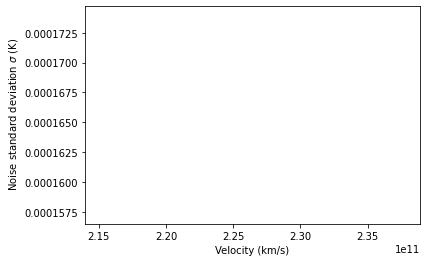

In [50]:
cubem_sclip = cubem_cutout.sigma_clip_spectrally(3)
mad_std_spectrum_sclip = cubem_sclip.mad_std(axis=(1, 2))
plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, 
         drawstyle='steps-mid')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

In [ ]:
mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))
plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, 
         drawstyle='steps-mid')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r' Noise standard deviation $\sigma$ (K)')